In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd

import lsst.geom as geom
from lsst.daf.persistence import Butler

In [2]:
dataIds = [dict(visit=411420, ccdnum=5),
           dict(visit=411420, ccdnum=10),
           dict(visit=419802, ccdnum=5),
           dict(visit=419802, ccdnum=10),
           dict(visit=411371, ccdnum=56),
           dict(visit=411371, ccdnum=60)]

In [3]:
tweakData = pd.read_parquet("/project/morriscb/src/ap_verify_ci_hits2015/wcsTweak")

In [4]:
tweakData.set_index("ccdVisit", inplace=True)

In [5]:
tweakData.drop_duplicates(inplace=True)

In [6]:
tweakData

,originRa,originDec,shift,shiftAngle,rot,affineXScale,affineYScale,affineXShear,affineYShear,startCornerRa0,...,startCornerDec3,endCornerRa0,endCornerDec0,endCornerRa1,endCornerDec1,endCornerRa2,endCornerDec2,endCornerRa3,endCornerDec3,fitSuccess
ccdVisit,,,,,,,,,,,,,,,,,,,,,
41137156,155.470285,-4.950050,0.0,-173.948814,-2.00,1.00000,1.0,0.00000,0.0,154.852198,...,-5.619048,154.829152,-5.596454,154.824060,-5.745554,155.124215,-5.756792,155.129392,-5.607597,False
41137156,155.470285,-4.950050,0.0,-173.948814,0.00,1.00000,1.0,0.00008,0.0,154.852198,...,-5.619048,154.852144,-5.618352,154.852279,-5.767537,155.152654,-5.768333,155.152601,-5.619048,True
41137156,155.470285,-4.950050,0.0,-173.948814,0.00,1.00443,1.0,0.00000,0.0,154.852198,...,-5.619048,154.849460,-5.618349,154.849607,-5.767534,155.151313,-5.768332,155.151247,-5.619048,True
41137156,155.470285,-4.950050,0.0,-173.948814,0.00,1.00000,1.0,0.00022,0.0,154.852198,...,-5.619048,154.852050,-5.618352,154.852163,-5.767537,155.152538,-5.768333,155.152507,-5.619048,True
41137156,155.470285,-4.950050,0.0,-173.948814,3.33,1.00000,1.0,0.00000,0.0,154.852198,...,-5.619048,154.892232,-5.652991,154.901097,-5.801915,155.201024,-5.785327,155.192234,-5.636299,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41980210,155.120152,-6.520078,0.0,147.337757,0.00,1.00000,1.0,0.00002,0.0,154.973294,...,-5.873407,154.973307,-5.873437,154.973220,-6.022987,155.274494,-6.022956,155.274376,-5.873407,True
41980210,155.120152,-6.520078,0.0,147.337757,5.99,1.00000,1.0,0.00000,0.0,154.973294,...,-5.873407,154.906256,-5.892190,154.921847,-6.040933,155.221477,-6.009666,155.205684,-5.860945,False
41980210,155.120152,-6.520078,0.0,147.337757,0.00,1.00000,1.0,0.00005,0.0,154.973294,...,-5.873407,154.973327,-5.873437,154.973235,-6.022987,155.274509,-6.022956,155.274396,-5.873407,True


In [7]:
tweakData.iloc[0]

originRa            155.47
originDec         -4.95005
shift                    0
shiftAngle        -173.949
rot                     -2
affineXScale             1
affineYScale             1
affineXShear             0
affineYShear             0
startCornerRa0     154.852
startCornerDec0   -5.61835
startCornerRa1     154.852
startCornerDec1   -5.76754
startCornerRa2     155.153
startCornerDec2   -5.76833
startCornerRa3     155.153
startCornerDec3   -5.61905
endCornerRa0       154.829
endCornerDec0     -5.59645
endCornerRa1       154.824
endCornerDec1     -5.74555
endCornerRa2       155.124
endCornerDec2     -5.75679
endCornerRa3       155.129
endCornerDec3      -5.6076
fitSuccess           False
Name: 41137156, dtype: object

In [8]:
def getCcdAttributes(data):
    output = []

    for idx, row in data.iterrows():
        outputRow = {}
        startCorners = makeSphpoints(row, "startCorner")
        endCorners = makeSphpoints(row, "endCorner")
        trueShiftDist = startCorners[0].separation(endCorners[0]).asArcseconds()
        trueRot = (endCorners[0].bearingTo(endCorners[1]) - startCorners[0].bearingTo(startCorners[1])).asDegrees()
        diff = []
        for startCornerIdx in range(3):
            for cornerIdx in range(startCornerIdx + 1, 4):
                diff.append(
                    np.fabs((endCorners[startCornerIdx].separation(endCorners[cornerIdx]) -
                             startCorners[startCornerIdx].separation(startCorners[cornerIdx])).asArcseconds()))
        distortMedian = np.median(diff)
        distortMean = np.mean(diff)
        outputRow["shift"] = trueShiftDist
        outputRow["rot"] = trueRot
        outputRow["distMean"] = distortMean
        outputRow["distMedian"] = distortMedian
        outputRow["fitSuccess"] = row["fitSuccess"]
        output.append(outputRow)
    
    return pd.DataFrame(data=output)
        
def makeSphpoints(row, name):
    corners = []
    for idx in range(4):
        corners.append(geom.SpherePoint(row[f"{name}Ra{idx}"],
                                        row[f"{name}Dec{idx}"],
                                        geom.degrees))
    return corners

In [9]:
trueTweaks = getCcdAttributes(tweakData)

<IPython.core.display.Javascript object>


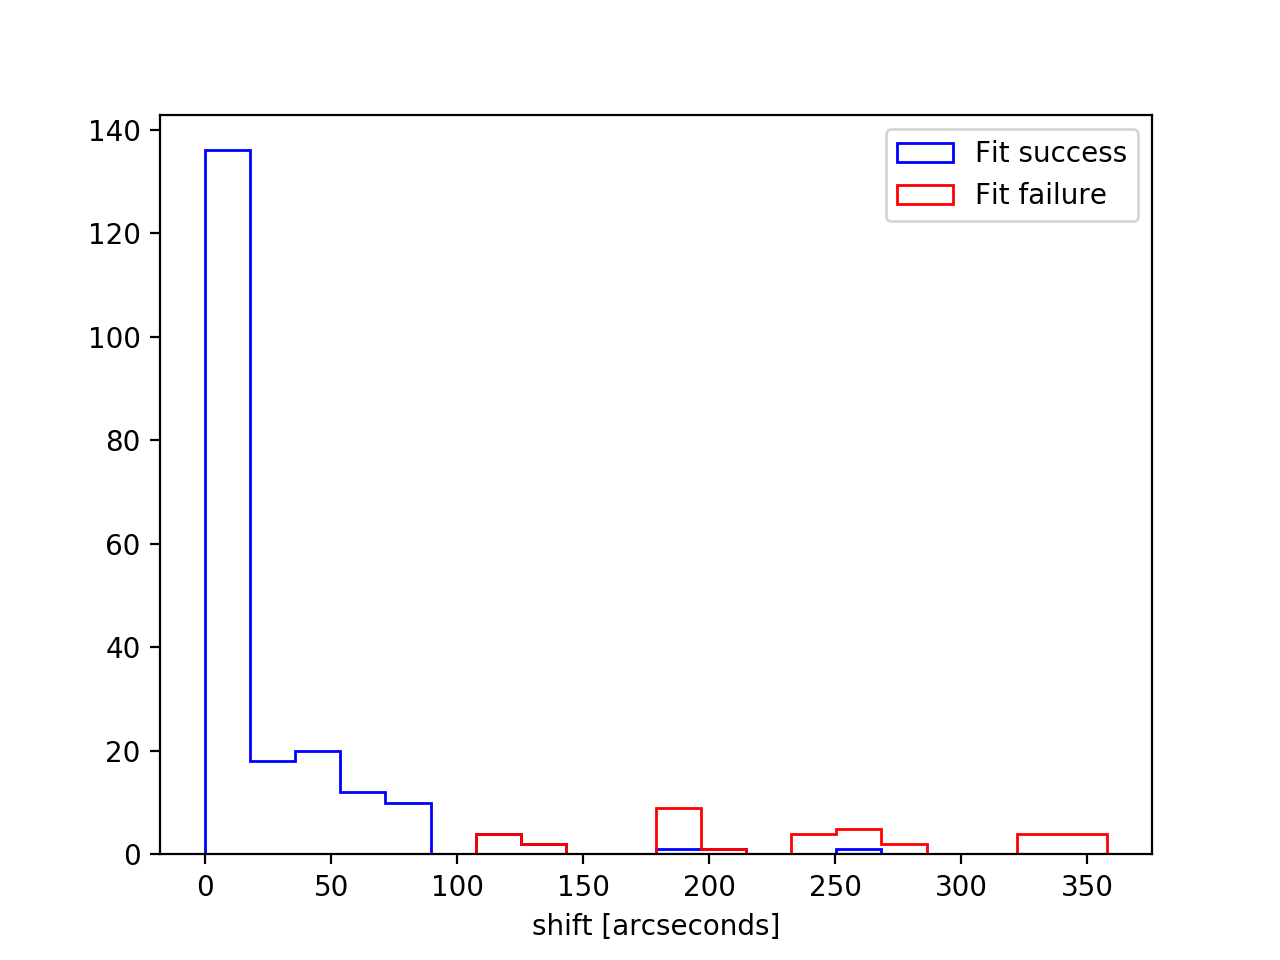

In [16]:
bins = np.linspace(trueTweaks["shift"].min(), trueTweaks["shift"].max(), 21)
plt.figure()
plt.hist(trueTweaks["shift"][trueTweaks["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(trueTweaks["shift"][~trueTweaks["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.xlabel("shift [arcseconds]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


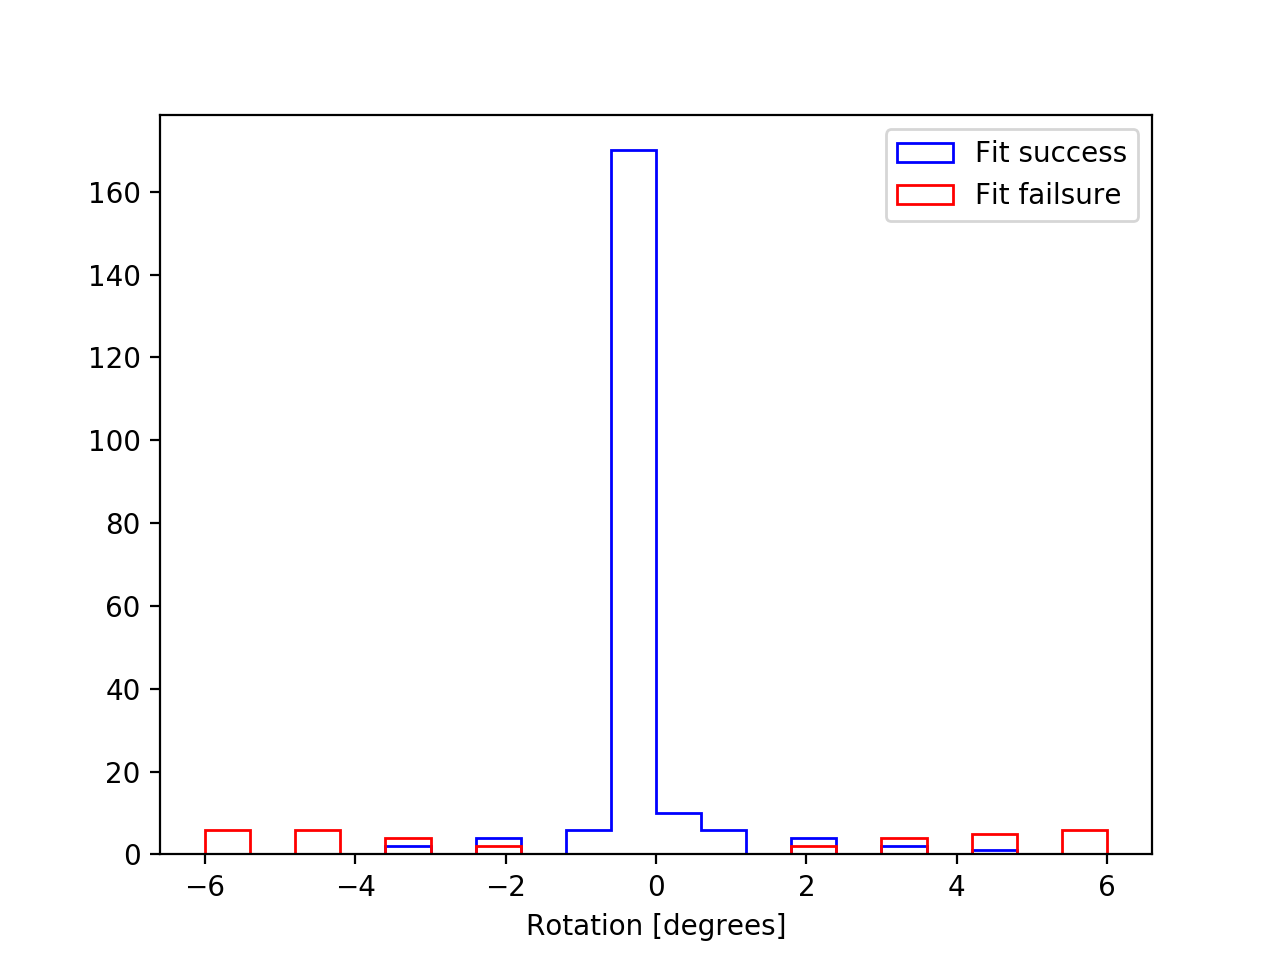

In [17]:
bins = np.linspace(trueTweaks["rot"].min(), trueTweaks["rot"].max(), 21)
plt.figure()
plt.hist(trueTweaks["rot"][trueTweaks["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(trueTweaks["rot"][~trueTweaks["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failsure")
plt.xlabel("Rotation [degrees]")
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


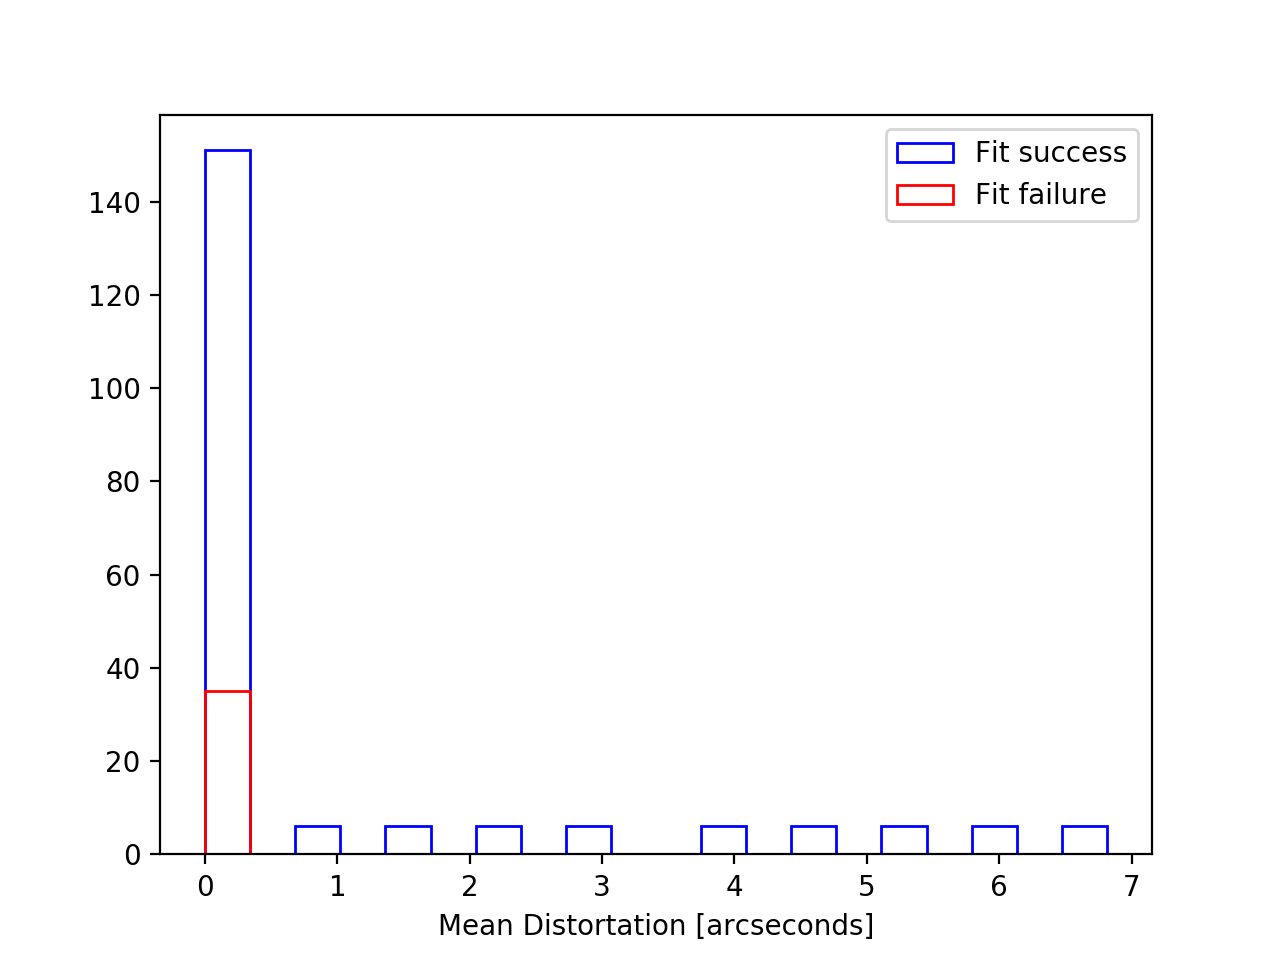

In [18]:
bins = np.linspace(trueTweaks["distMean"].min(), trueTweaks["distMean"].max(), 21)
plt.figure()
plt.hist(trueTweaks["distMean"][trueTweaks["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(trueTweaks["distMean"][~trueTweaks["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.legend(loc=0)
plt.xlabel("Mean Distortation [arcseconds]")
plt.show() 

<IPython.core.display.Javascript object>


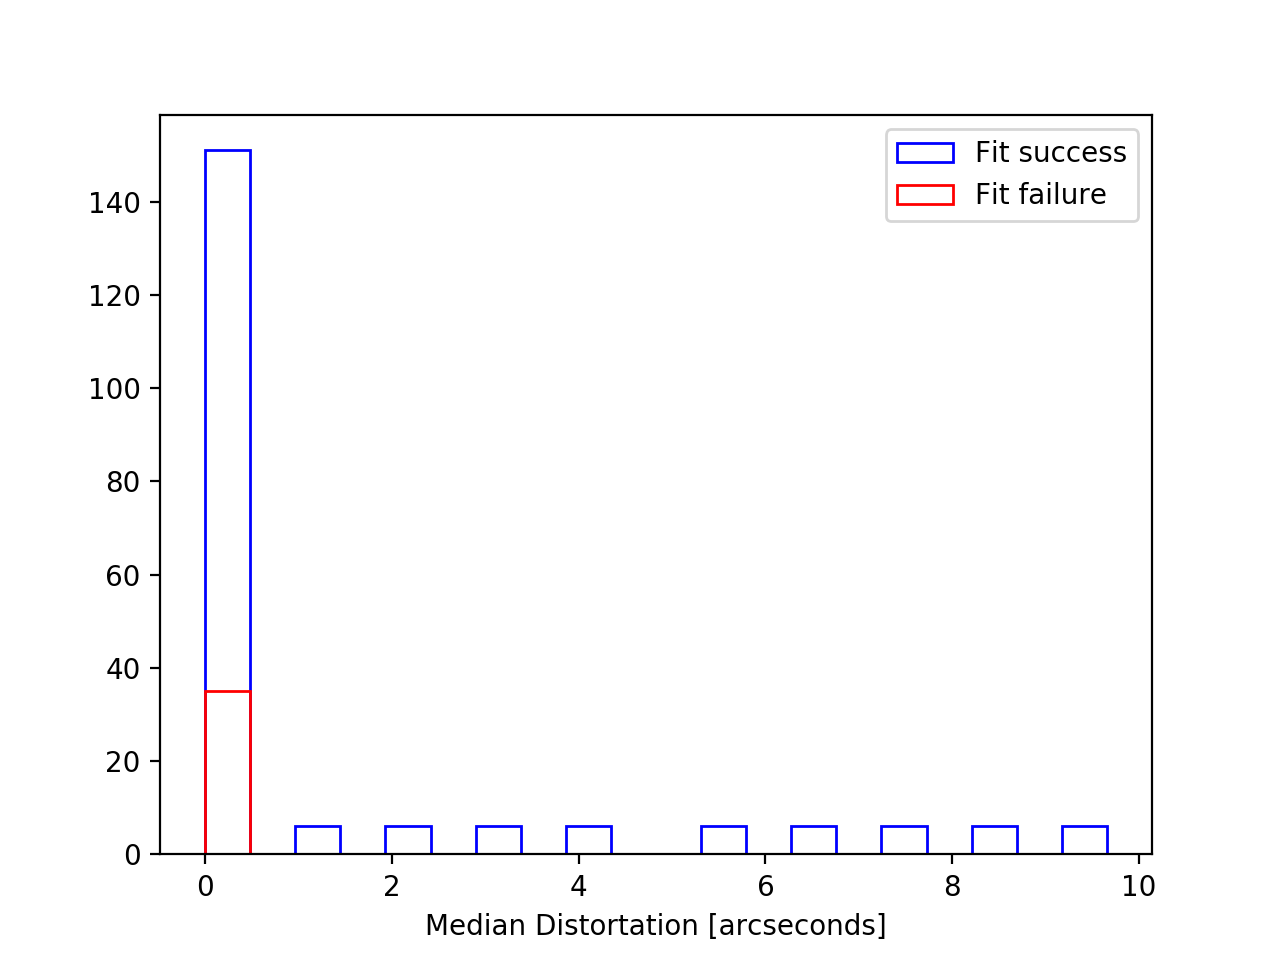

In [20]:
bins = np.linspace(trueTweaks["distMedian"].min(), trueTweaks["distMedian"].max(), 21)
plt.figure()
plt.hist(trueTweaks["distMedian"][trueTweaks["fitSuccess"]], histtype="step", color="b",
         bins=bins, label="Fit success")
plt.hist(trueTweaks["distMedian"][~trueTweaks["fitSuccess"]], histtype="step", color="r",
         bins=bins, label="Fit failure")
plt.legend(loc=0)
plt.xlabel("Median Distortation [arcseconds]")
plt.show() 

<IPython.core.display.Javascript object>


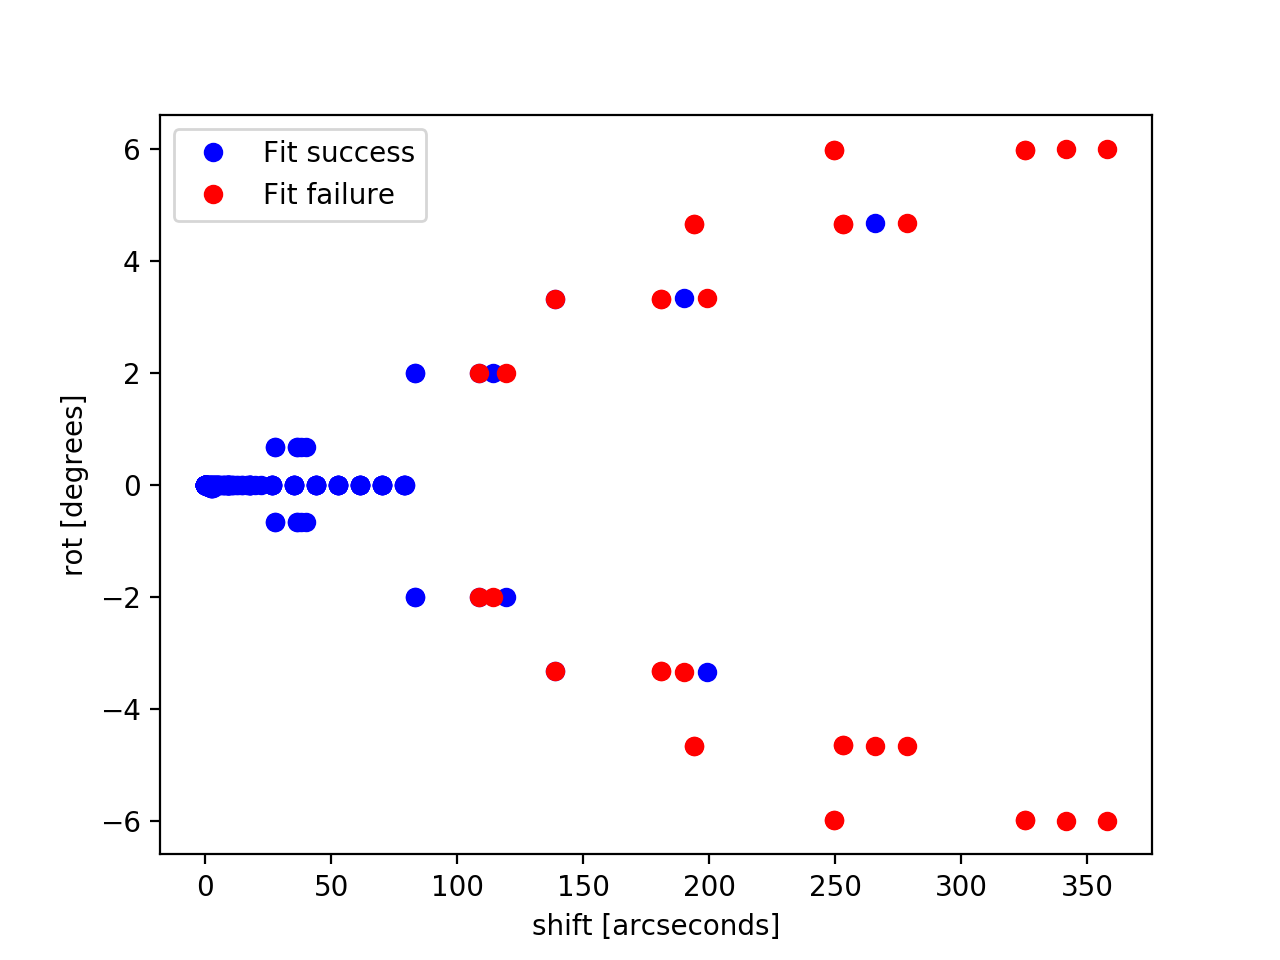

In [26]:
plt.figure()
plt.plot(trueTweaks["shift"][trueTweaks["fitSuccess"]],
         trueTweaks["rot"][trueTweaks["fitSuccess"]],
         "bo", label="Fit success")
plt.plot(trueTweaks["shift"][~trueTweaks["fitSuccess"]],
         trueTweaks["rot"][~trueTweaks["fitSuccess"]],
         "ro", label="Fit failure")
plt.legend(loc=0)
plt.xlabel("shift [arcseconds]")
plt.ylabel("rot [degrees]")
plt.show()

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.999     , 1.0001062 , 1.00121363, 1.00232228, 1.00343216,
        1.00454327, 1.0056556 , 1.00676917, 1.00788397, 1.009     ,
        1.011     ]),
 <a list of 1 Patch objects>)

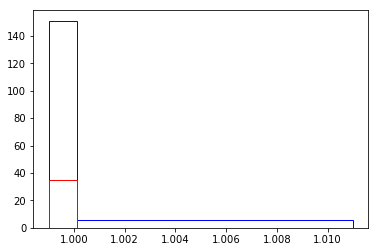

In [50]:
hist(tweakData["affineXScale"][tweakData["fitSuccess"]],
     bins=scaleBins, color='b', histtype='step')
hist(tweakData["affineXScale"][np.logical_not(tweakData["fitSuccess"])],
     bins=scaleBins, color='r', histtype='step')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([9.00000000e-06, 1.56810054e-05, 2.68255940e-05, 4.54158883e-05,
        7.64263683e-05, 1.28154967e-04, 2.14443469e-04, 3.58381366e-04,
        5.98484250e-04, 9.99000000e-04, 1.00100000e-03]),
 <a list of 1 Patch objects>)

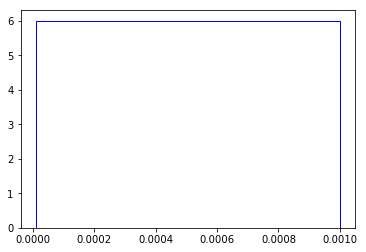

In [70]:
hist(tweakData["affineXShear"][tweakData["fitSuccess"]],
     bins=shearsBins, color='b', histtype='step')
hist(tweakData["affineXShear"][np.logical_not(tweakData["fitSuccess"])],
     bins=shearsBins, color='r', histtype='step')

(array([175.,   6.,   6.,   6.,   0.,   6.,   0.,   0.,   0.,   6.]),
 array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
        0.0008, 0.0009, 0.001 ]),
 <a list of 10 Patch objects>)

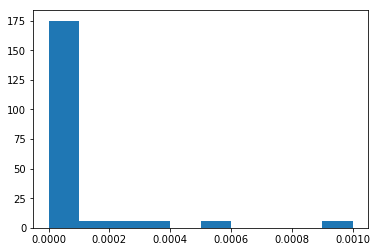

In [66]:
hist(tweakData["affineXShear"][tweakData["fitSuccess"]])